# Milestone - Random Forets

### 1. Data importing

In [27]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, make_scorer
import seaborn as sns
import warnings

The first step consists on importing the csv fieles for train and test dataset, as they were already divided in the previous preprocessing steps.

In [8]:
# Import train and test datasets in csv format
data_train = pd.read_csv('OpenData/ames_train_clean.csv')
data_test = pd.read_csv('OpenData/ames_test_clean.csv')

As a second step, we will connvert the train and test datasets into NumPy arrays, extracting also the variables' names as an independent vector.

In [20]:
# Creating train and test dataframes
X_train = data_train.drop(columns = ['PID', 'SoldPrice'])
X_test = data_test.drop(columns = ['PID', 'SoldPrice'])
X_names = data_train.drop(columns = ['PID', 'SoldPrice']).columns.tolist()

Y_train = data_train['SoldPrice']
Y_test = data_test['SoldPrice']

After that, as done in the previous notebook, we will define our own score metrics, which correspond to the accuracy metrics we defined at the start of the project (`RMSE`, `RMSLE` and `R2`)

In [34]:
# Function for calculating RMSE
def rmse(y_test, y_pred):
    """
    This function calculates the RMSE between the predicted and the actual values
    -------------------------------------------
    Parameters:
    y_test (array): Array of actual values
    y_pred (array): Array of predicted values

    Returns:
    float: RMSE value
    """
    
    return np.sqrt(mean_squared_error(y_test, y_pred))
# Define a custom scorer for RMSE
rmse_scorer = make_scorer(rmse)

def rmsle(y_test, y_pred):
    """
    This function calculates the RMSLE between the predicted and the actual values
    -------------------------------------------
    Parameters:
    y_test (array): Array of actual values
    y_pred (array): Array of predicted values
    
    Returns:
    float: RMSLE value
    """
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

# Define a custom scorer for RMSLE
rmsle_scorer = make_scorer(rmsle)

# Define a custom scorer for R2
r2_scorer = make_scorer(r2_score)

### 2. Hyperparameter tuning
In this notebook, we will apply a random forest model to predict the properties' sold price, as we did previously with the linear regression models. For this, as we have a regression problem, we will use the scikit function `RandomForestRegressor()`

The random forest model requires tuning two main parameters:

- **`n_estimators`:** number of trees in the forest
- **`max_features`:** number of features to take into account when looking for the best split

The tuning will be done in two steps: 

First we will tune the `n_estimators` parameter, with `max_features=None.`
Once we have found the `n_estimators` optimal parameter, we will tune `max_features` using `gridsearchCV` to find the value that gives the best performance. 
Finally we will check again the `n_estimators` parameter, with the newly defined `max_features`, to see if an adjustment is necessary.

#### 2.1. Tuning `n_estimators`
We will first tune the `n_estimators` paramater. For this step, `max_features` is set to None, which will consider the total number of variables. 

We will calculate the OOB error for random forest models with different numbers of trees, from a minimum of 100 to a maximum of 1500 in steps of 50. Finally, the OOB error will be plotted for each n_estimators tested value for visually inspecting at which value the error stabilizes.

c:\Users\cande\anaconda3\envs\scientific\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


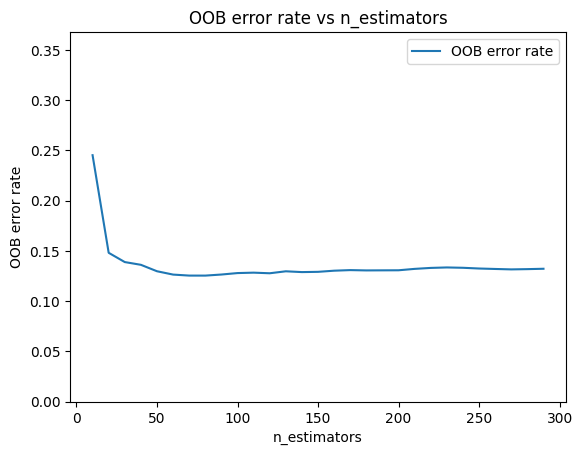

In [21]:
# Create an empty list for OBB error and i values iteration
error_rate = []
i_list = []

# Define a loop to iterate over the different values of n_estimators
for i in range(10, 300, 10):
    # warm_start = true: reuse the solution of the previous iteration, adding more estimators (otherwise a whole neww tree would be created)
    # random_state = 33: allows reproducibility, giving the same results each time the codeblock is run
    # oob_score = true: sets oob score as the metric for generalisation score
   
    rf = RandomForestRegressor(warm_start=True, n_estimators=i, max_features=None, random_state=33, oob_score=True)
    rf.fit(X_train, Y_train)

    # oob_score attribute returns the accuracy, but we are interested on the error itself (then: 1-oob_score)
    oob_error = 1 - rf.oob_score_

    # Append OOB error rate and i values to the lists
    error_rate.append(oob_error)
    i_list.append(i)
  

# Plot n_esitmators vs OOB error

plt.plot(i_list, error_rate, label="OOB error rate")
plt.ylim(0, 1.5*max(error_rate)) 
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title("OOB error rate vs n_estimators")
plt.legend(loc="upper right")
plt.show()

Based on the obtained graphic, we can conclude that the OOB error gets stabilized when `n_estimators` reaches 50. Consequently, we will use this value for the model and for calibrating the next hyperparameter - `max_features`.

#### 2.2 Tuning max_features
Once we have tuned the `n_estimators` parameter, we will use that for tuning the `max_features` parameter. 

We will tune this parameter using Cross Validation technique, with 5 k-folds, which means that 20% of the data will be used for testing purpose at each iteration, which is a generalized standard value for this task.

We will tune the hyperparameter based on the acuracy and std scores of our main accuracy metric defined at the beggining of the project, `RMSLE`.


In [36]:
# Define scoring metrics
scoring = {'RMSLE': rmsle_scorer}

# Create a dict of possible max_features values
cv_vals = {'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

# Define the model
# n_estimators=50 based on the previous parameter tuning step
# random_state = 33: allows reproducibility, giving the same reuslts each time the notebook is ran
rf = RandomForestRegressor(n_estimators=50, random_state=33)

# cv=5 for 5 k-folds
# scoring gets the defined scoring metrics
# refit=Flase allows calculaitng more than one metric
gridsearch_cv1 = GridSearchCV(estimator=rf, param_grid=cv_vals, cv=5, scoring=scoring, refit= False)
gridsearch_cv1.fit(X_train, Y_train)

results_cv1=pd.DataFrame(gridsearch_cv1.cv_results_)[["params", "mean_test_RMSLE", "std_test_RMSLE"]]
print(round(results_cv1, 2))

                  params  mean_test_RMSLE  std_test_RMSLE
0  {'max_features': 0.1}             0.14            0.03
1  {'max_features': 0.2}             0.13            0.03
2  {'max_features': 0.3}             0.13            0.03
3  {'max_features': 0.4}             0.13            0.03
4  {'max_features': 0.5}             0.14            0.03
5  {'max_features': 0.6}             0.14            0.03
6  {'max_features': 0.7}             0.14            0.03
7  {'max_features': 0.8}             0.14            0.03
8  {'max_features': 0.9}             0.14            0.03


According to the results obtained with CrossValidation, we will tune the max_features parameter to 0.3. This is because 0.3 is the value that shows a better VER ACA values that show a better trade-off between mean test score and mean sandard deviation test score. Moreover, 1/3 of the data is generally considered as a good proportion for max features in random forest (Hastie, Tibshirani, & Friedman, 2009, p. 592).

#### 2.3. Re-testing n_estimators value
As the value of `max_features` changed, after tuning, from the one that was originally considered when tuning `n_estimators`, we will test again if `n_estimators`=`50` is a good value for a random forest model with `max_features`=`0.3`

d:\Programs\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


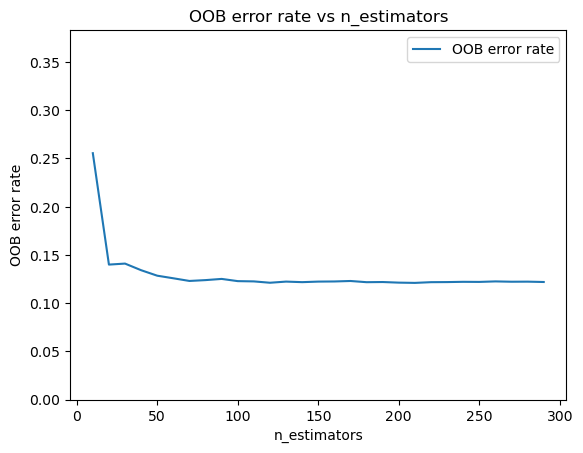

In [19]:
# Create an empty list for OBB error and i values iteration
error_rate = []
i_list = []

# Define a loop to iterate over the different values of n_estimators
for i in range(10, 300, 10):
    # We use the same configuration as in the tuning, but now max_features= 0.3
    rf = RandomForestRegressor(warm_start=True, n_estimators=i, max_features=0.3, random_state=33, oob_score=True)
    rf.fit(X_train, Y_train)

    # oob_score attribute returns the accuracy, but we are interested on the error itself (then: 1-oob_score)
    oob_error = 1 - rf.oob_score_

    # Append OOB error rate and i values to the lists
    error_rate.append(oob_error)
    i_list.append(i)
    
# Plot n_esitmators vs OOB error
plt.plot(i_list, error_rate, label="OOB error rate")
plt.ylim(0, 1.5*max(error_rate)) 
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title("OOB error rate vs n_estimators")
plt.legend(loc="upper right")
plt.show()

We can see that, even after changing the max_features parameter value, n_estimators=50 seems to be small, to we will finally tune it to 75

#### 2.4. Applying the final Random Forest model
Now we will train the final model with the tuned hyperparameters and compute the OOB error.

In [10]:
rf1 = RandomForestRegressor(n_estimators = 75, max_features= 0.3, oob_score=True, random_state=33)
# Step 2: build the random forest on the train set by indicating the input data and the target variable 
rf1.fit(X_train, Y_train)

c:\Users\cande\anaconda3\envs\scientific\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_features=0.3, n_estimators=75, oob_score=True,
                      random_state=33)

In [5]:
# OOB error
print(f'OOB error: {round(1-rf1.oob_score_, 2)}')

OOB error: 0.12


## ADD OOB ERROR CONCLUSSION

### 2. Measure the importance of variables
Once the final model is trained, we will analyze the importance of the different variables. For this we will use the Mean Decrease in Accuracy metric (MDA), which calculates the difference between the error of the forest on Tm and the error of the forestpermuted sample e T jm. We decide to use this metric instead of Gini Impurity, other popular metric, because MDA has been demonstrated to be more robust when fealling with variables of different scales and when there are correlations between predictive variables (Nicodemus, 2011 & Han et al. 2016). These two characteristics are present in our datasetm as it was analyzed in the EDA.

## CHECK N_REPEATS PARAM VALUE
## EDIT A BIT THIS CODE AS IT WAS TAKEN FROM AUDREYS NOTEBOOK (and maybe use other graph)


In [11]:
result = permutation_importance(rf1, X_train, Y_train, n_repeats=10, random_state=33, n_jobs=-1)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

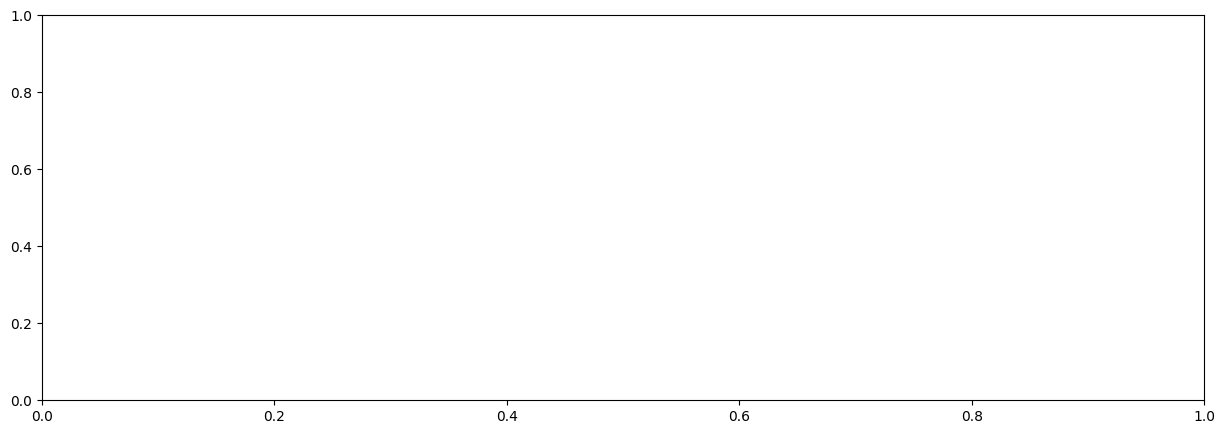

In [12]:
## Plot of the MDA for the 15 features with the highest average MDA
sorted_idx = result.importances_mean.argsort()
invert_sorted_idx=sorted_idx[::-1][:15]# keep only the 15 features with the highest average MDA
fig, ax = plt.subplots(figsize=(15,5))
ax.boxplot(result.importances[invert_sorted_idx].T,
           vert=False, labels=X_train.columns[invert_sorted_idx])
# increase the size of x axis interval
ax.set_xlim(0.004,0.13)
ax.set_title("MDA computed on the test set for the 15 features with the highest average MDA")
fig.tight_layout()
plt.show()

### 3. Variable selection
In this section we will select the variables that will be used for training the final model. For this, we use boruta feature selection strategy. Boruta algorithm iteratively removes the features of less relevance to the prediction, based on a statistical test [(Kursa & Rudnicki, 2010)](https://www.jstatsoft.org/article/view/v036i11). The [Boruta python package](https://github.com/scikit-learn-contrib/boruta_py) provides an impleentation of this algorithm.

We pick Boruta because of two reasons: One, we do not want to specify the number of variables to be selected, in case we miss out on important ones due to such a limit, this is a limitation with Recurisve Feature Elimination (RFE) because the user needs to specify this limit [(Samo, 2022)](https://blog.kxy.ai/effective-feature-selection/index.html#limits). And two, Boruta requires far fewer iterations compared to RFE, which is a big advantage when working with large datasets *(Ibid)*. 

Instructions before using boruta:
1. Install the package using `!pip install boruta`
2. Make the following changes to the burata.py file in case the below code blocks throw error and change all the occurances of these datatypes:
    - `np.int` to `np.int32`, 
    - `np.float` to `np.float64` and 
    - `np.bool` to `np.bool_` in the boruta.py file. 

This is because the boruta package has not been updated for the latest version of numpy.

In [4]:

#  !pip install Boruta
from boruta import BorutaPy

## Explain the choice of parameters in Boruta here ---

In [5]:
rf = RandomForestRegressor(n_estimators=75,n_jobs=-1, max_features=None,oob_score=True,random_state=33)
rf.fit(X_train, Y_train)

# define Boruta feature selection method
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=33)

# find all relevant features
boruta.fit(X_train.values, Y_train.values)

BorutaPy(estimator=RandomForestRegressor(max_features=None, n_estimators=60,
                                         n_jobs=-1, oob_score=True,
                                         random_state=RandomState(MT19937) at 0x10E88FFD440),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x10E88FFD440)

In [6]:
boruta.support_

array([ True,  True,  True, False, False, False, False, False,  True,
       False, False,  True,  True, False, False,  True, False, False,
       False,  True, False, False, False,  True, False, False,  True,
        True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [7]:
boruta.ranking_

array([  1,   1,   1, 174,  55,  35, 181,  52,   1,  11,   3,   1,   1,
         2,  36,   1,  96,  22,   8,   1,  85,  69,   4,   1,  21,  98,
         1,   1,  15,  67,   2,  27,  13,  93,   1,   6,  44,   7,  10,
         5,  20,   1,   1, 111,  75, 106,   3,   2,  63, 130,   9, 163,
       127,  89,  63,   2,  17,  75, 160, 102,  54, 170, 158,  79, 121,
        92, 104,  70, 169, 145, 105, 158,  81,  41,  14,  48,  53,  28,
        65,  72, 117, 144,  63, 141,  76, 168, 114,  58,  19,  12, 128,
       172, 163, 122,  41,  84,  23,  34, 120, 156, 110, 114,  78,  16,
       110,  24, 133,  92,  69, 107, 108, 125, 152, 182, 155, 178, 116,
        95,  78,  30, 138,  94, 115, 112,  89,  60, 148,  41, 143,  98,
       167,  43, 173,  46,  87, 129,  84, 183, 139, 167,  87, 143, 150,
        34,  32,  81, 100, 148,  49,  71, 146, 163, 178,  59,  39, 125,
        82, 159,  99, 148,  18,  73, 101, 119,  45, 125,  56, 131,  38,
        50, 136, 178, 185, 185, 132, 123, 118, 154,  47, 136,  9

In [21]:
boruta_subset = [f for f,s in zip(X_train.columns, boruta.support_) if s]
print(boruta_subset)
print(len(boruta_subset))

['BldgArea', 'LotFrontage', 'LotArea', 'OverallQual', 'YearRemodAdd', 'MasVnrArea', 'BsmtQual', 'BsmtFinSF1', 'TotalBsmtSF', 'X1FloorSF', 'X2FloorSF', 'KitchenQual', 'GarageCars', 'GarageArea']
14


Boruta has selected the following 14 variables as relevant for the prediction::
`['BldgArea'`, `'LotFrontage'`, `'LotArea'`, `'OverallQual'`, '`YearRemodAdd'`, `'MasVnrArea'`, `'BsmtQual'`, `'BsmtFinSF1'`, `'TotalBsmtSF'`, `'X1FloorSF'`, `'X2FloorSF'`, `'KitchenQual'`, `'GarageCars'`, `'GarageArea']`

We can use these variables to train the final model.

In [26]:
# this codeblock is just to check how much the results match with the MDA - we dont use this intersection for training
intersection = np.intersect1d(boruta_subset,X_train.columns[invert_sorted_idx])
print(intersection)
print(len(intersection))

['BldgArea' 'BsmtFinSF1' 'BsmtQual' 'GarageArea' 'GarageCars'
 'KitchenQual' 'LotArea' 'MasVnrArea' 'OverallQual' 'TotalBsmtSF'
 'X1FloorSF' 'X2FloorSF' 'YearRemodAdd']
13


### 4. Evaluate test performance
Evaluate the test performance of the two random forest models (based on the full set of variables or a subset) and determine the configuration of the best model (based on the main evaluation metric you selected in step 1).

In [25]:
# Using the subset of variables selected by Boruta
X_train_new = X_train[boruta_subset]
X_test_new = X_test[boruta_subset]

rf2 = RandomForestRegressor(n_estimators = 75, n_jobs=-1, max_features= 0.3, oob_score=True, random_state=33)
rf2.fit(X_train_new, Y_train)
y_pred2 = rf2.predict(X_test_new)
print('R2 on test set: ', round(rf2.score(X_test_new, Y_test),2))
print('RMSLE on test set: ', round(rmsle(Y_test, y_pred2),2))


R2 on test set:  0.89
RMSLE on test set:  0.14


#### Conclusion
- Accuracy score (r2 score) and the RMSLE - with and without the variable selection: we observe that the value for our main evaluation metric RMSLE is only marginally higher (Delta = 0.01) for the model trained with the subset of selected variables **(R2=0.89, RMSLE=0.14)** compared to the model with entire set **(R2= 0.89, RMSLE = 0.13)**. This is a very small difference, so we can conclude that the model trained with the subset of variables is as good as the one trained with the full set of variables. This is a very good result, as it means that we can use a model with less variables, which is easier to interpret and less prone to overfitting, without losing performance.

- Comparison with Milestone 2: In our previous milestone we explored linear regression models - with and without regularization. In case of without regularization, we obtained R2 of -ve inf and RMSLE couldn't be calculated. In case of ElasticNet regularization, we obtained an **R2 of 0.76** and an **RMSLE of 0.16**. We can cocnlude that our random forest model performs better than the ElasticNet model because even the RMSLE for RF is only marginally higher, the R2 is significantly improved with RF.

### References
Kristin K. Nicodemus, Letter to the Editor: On the stability and ranking of predictors from random forest variable importance measures, Briefings in Bioinformatics, Volume 12, Issue 4, July 2011, Pages 369–373, https://doi.org/10.1093/bib/bbr016

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer. URL: https://link.springer.com/book/10.1007/978-0-387-84858-7

Hong Han, Xiaoling Guo and Hua Yu, "Variable selection using Mean Decrease Accuracy and Mean Decrease Gini based on Random Forest," 2016 7th IEEE International Conference on Software Engineering and Service Science (ICSESS), Beijing, 2016, pp. 219-224, doi: 10.1109/ICSESS.2016.7883053.

Kursa, M. B., & Rudnicki, W. R. (2010). Feature Selection with the Boruta Package. Journal of Statistical Software, 36(11), 1 - 13. doi:http://dx.doi.org/10.18637/jss.v036.i11

Samo, K. (2022, January 3). Effective Feature Selection. Retrieved from https://blog.kxy.ai/effective-feature-selection/index.html#limits
